In [1]:
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import pyomo.environ as pe
import pyomo.opt as po

In [2]:
nodes_filename = os.path.join('data', 'nodes.txt')
edges_filename = os.path.join('data', 'edges.txt')
distance_filename = os.path.join('data', 'distance.csv')
pos_filename = os.path.join('data', 'pos.csv')

In [3]:
nodes = []
with open(nodes_filename) as fh:
    for line in fh:
        nodes.append(int(line.strip()))
nodes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [4]:
edges = []
with open(edges_filename) as fh:
    for line in fh:
        edge = tuple(int(i) for i in line.strip().split(','))
        edges.append(edge)
edges

[(0, 1),
 (0, 2),
 (0, 3),
 (1, 4),
 (1, 6),
 (2, 1),
 (2, 3),
 (2, 5),
 (3, 5),
 (4, 2),
 (5, 7),
 (5, 8),
 (6, 4),
 (6, 7),
 (6, 9),
 (7, 4),
 (7, 9),
 (8, 3),
 (8, 7),
 (8, 9)]

In [5]:
df_distance = pd.read_csv(distance_filename, index_col=[0,1], header=0)
display(df_distance)
distance = df_distance['distance'].to_dict()
display(distance)

distance
0 1        40
  2         8
  3        10
1 4         6
  6        10
2 1         4
  3        12
  5         2
3 5         1
4 2         2
5 7         4
  8         3
6 4         8
  7        20
  9         1
7 4         0
  9        20
8 3         6
  7        10
  9         2

{(0, 1): 40,
 (0, 2): 8,
 (0, 3): 10,
 (1, 4): 6,
 (1, 6): 10,
 (2, 1): 4,
 (2, 3): 12,
 (2, 5): 2,
 (3, 5): 1,
 (4, 2): 2,
 (5, 7): 4,
 (5, 8): 3,
 (6, 4): 8,
 (6, 7): 20,
 (6, 9): 1,
 (7, 4): 0,
 (7, 9): 20,
 (8, 3): 6,
 (8, 7): 10,
 (8, 9): 2}

In [6]:
df_pos = pd.read_csv(pos_filename, index_col=[0], header=0)
display(df_pos)
pos = {idx: tuple(v) for idx, v in df_pos.iterrows()}
display(pos)

,x,y
0,4,0
1,0,0
2,4,2
3,8,0
4,2,4
5,6,4
6,0,8
7,4,6
8,8,8
9,4,8


{0: (4, 0),
 1: (0, 0),
 2: (4, 2),
 3: (8, 0),
 4: (2, 4),
 5: (6, 4),
 6: (0, 8),
 7: (4, 6),
 8: (8, 8),
 9: (4, 8)}

In [7]:
graph = nx.DiGraph()
graph.add_nodes_from(list(nodes))
graph.add_edges_from(list(edges))

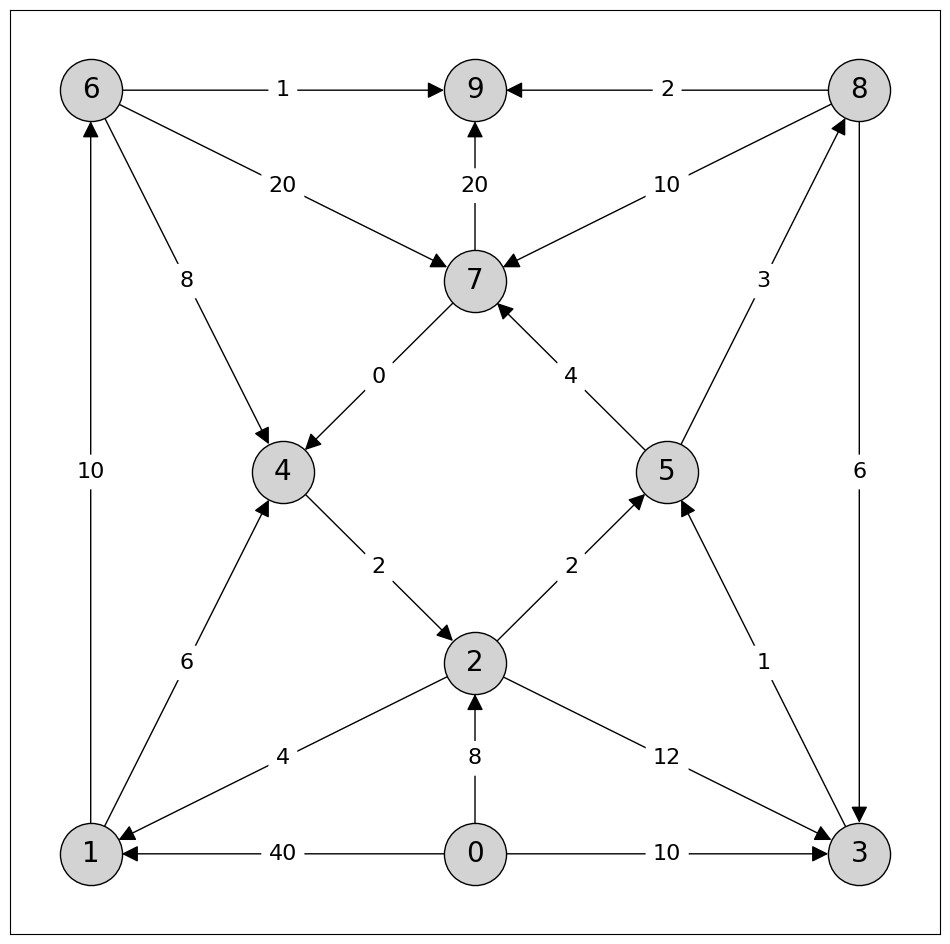

In [8]:
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx_nodes(graph, pos=pos, ax=ax, node_color='lightgray',
                       edgecolors='black', node_size=2000)
nx.draw_networkx_labels(graph, pos=pos, ax=ax, labels=dict(zip(nodes, nodes)),
                        font_size=20)
nx.draw_networkx_edges(graph, pos=pos, ax=ax, node_size=2000, arrowsize=25)
nx.draw_networkx_edge_labels(graph, pos=pos, ax=ax, edge_labels=distance,
                             font_size=16, rotate=False)
plt.show()

In [9]:
delta_neg = defaultdict(set)
delta_pos = defaultdict(set)
for (i, j) in edges:
    delta_neg[i].add(j)
    delta_pos[j].add(i)

In [10]:
instance = pe.ConcreteModel()

In [11]:
instance.nodes = pe.Set(initialize=nodes)
instance.s = 0
instance.t = 9
instance.edges = pe.Set(within=instance.nodes*instance.nodes, initialize=edges)

In [12]:
instance.distance = pe.Param(instance.edges, initialize=distance)
instance.delta_neg = pe.Param(instance.nodes, initialize=delta_neg, within=pe.Any, default=set())
instance.delta_pos = pe.Param(instance.nodes, initialize=delta_pos, within=pe.Any, default=set())

In [13]:
instance.x = pe.Var(instance.edges, domain=pe.Reals, bounds=(0, 1))

In [14]:
def shortest_path(instance):
    return sum(instance.distance[i, j] * instance.x[i, j]
               for (i, j) in instance.edges)

instance.shortest_path = pe.Objective(sense=pe.minimize, rule=shortest_path)

In [15]:
def flow_balance(instance, i):
    flow_in = sum([instance.x[j, i] for j in instance.delta_pos[i]])
    flow_out = sum([instance.x[i, j] for j in instance.delta_neg[i]])
    if i == instance.s:
        constraint = (flow_out == 1)
    elif i == instance.t:
        constraint = (flow_in == 1)
    else:
        constraint = (flow_in == flow_out)
    return constraint

instance.flow_balance = pe.Constraint(instance.nodes, rule=flow_balance)

In [17]:
solver = po.SolverFactory('gurobi')
result = solver.solve(instance)

In [18]:
i = int(instance.s)
path_nodes = [i]
path_edges = []
stop = False
while not stop:
    for j in delta_neg[i]:
        if instance.x[i, j].value == 1:
            if j == int(instance.t):
                stop = True
            path_nodes.append(j)
            path_edges.append((i, j))
            i = j
            break

In [19]:
node_colors = ['lightblue' if i in path_nodes else 'lightgray'
               for i in graph.nodes()]
edge_colors = ['blue' if (i, j) in path_edges else 'black'
               for (i, j) in graph.edges()]
edge_widths = [2 if (i, j) in path_edges else 1
               for (i, j) in graph.edges()]

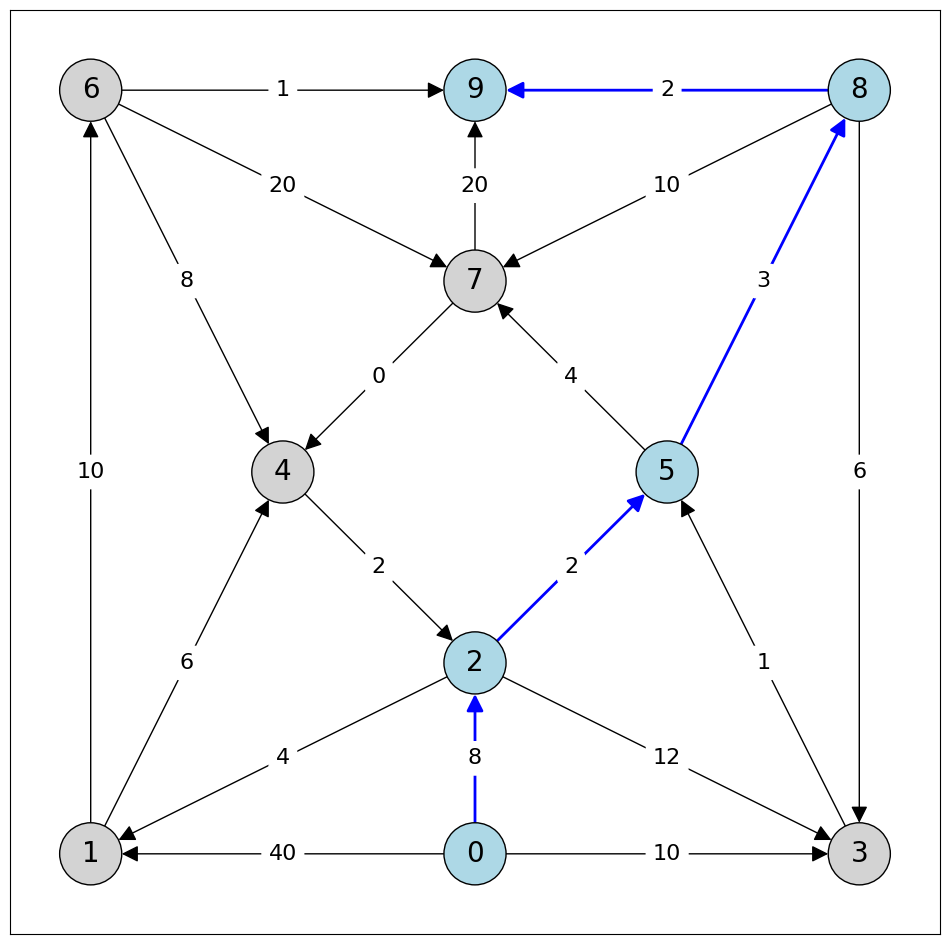

In [20]:
fig, ax = plt.subplots(figsize=(12, 12))

nx.draw_networkx_nodes(graph, pos=pos, ax=ax, node_color=node_colors,
                       edgecolors='black', node_size=2000)
nx.draw_networkx_labels(graph, pos=pos, ax=ax, labels=dict(zip(nodes, nodes)),
                        font_size=20)
nx.draw_networkx_edges(graph, pos=pos, ax=ax, node_size=2000, arrowsize=25,
                       edge_color=edge_colors, width=edge_widths)
nx.draw_networkx_edge_labels(graph, pos=pos, ax=ax, edge_labels=distance,
                             font_size=16, rotate=False)
nx.draw_networkx_edges
plt.show()